### An Example of Transfer Learning for Image Classification

Transfer Learning is the re-use of pre-trained models on new tasks. Most often, the two tasks are different but somehow related to each other. For example, a model which was trained on image classification might have learnt image features which can also be harnessed for other image related tasks. This technique became increasingly popular in the field of Deep Learning since it enables one to train a model on comparatively little data.

### Table of Contents

#### 1. [Setup](#Setup)
#### 2. [Data loading and pre-processing](#Data-loading-and-pre-processing)
#### 3. [Loading a pre-trained model](#Loading-a-pre-trained-model)
#### 4. [Training the last layer](#Training-the-last-layer)

---

# Setup

In this notebook, we consider the [Alien vs Preditor](https://www.kaggle.com/pmigdal/alien-vs-predator-images) task from [Kaggle](http://www.kaggle.com). We want to classify images as either 'aliens' or 'predators'.

Because the dataset is relatively small, and we don't want to wait for hours, we use a model pre-trained on the very large ImageNet task.

![Transfer Learning Figure 1](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-1.png?raw=1)

To reduce the difficulty of training, we freeze the intermediate layers and only train a few layers close to the output.

![Transfer Learning Figure 2](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/transfer-learning-2.png?raw=1)
Figures taken from https://www.kaggle.com/pmigdal/alien-vs-predator-images

---
### Requirements

Execute this cell to download the alien-vs-predator dataset and to install some dependencies. Google Colab will offer you to restart the kernel after you did this. Please do so.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

If all went well, you should be able to execute the following cell successfully.

In [ ]:
import os

import torch
import torch.nn as nn

import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', size=16)

---

# Data loading and pre-processing

Here we will create a `Dataset` and corresponding `DataLoader` that find training examples in the following directory structure:

```
data/alien-vs-predator
│
└───train
│     │
│     │───alien
│     │    │   20.jpg
│     │    │   104.jpg
│     │    └   ...
│     │
│     └───predator
│          │   1.jpg
│          │   78.jpg
│          └   ...
│   
└───validation
      │
      │───alien
      │    │   233.jpg
      │    │   12.jpg
      │    └   ...
      │
      └───predator
           │   22.jpg
           │   77.jpg
           └   ...
```

`torchvision` datasets allow us to specify many different transformation on the inputs. Random perturbations can improve the quality of your model by synthetically enlarging your dataset.

Here i download the dataset from kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pmigdal/alien-vs-predator-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/alien-vs-predator-images


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,

)
from torch.utils.data import DataLoader

# Create datasets
from PIL import Image
from torchvision import transforms
import torch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
g = torch.Generator()
g.manual_seed(seed)

train_data = ImageFolder(
    os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "train"),
    transform=Compose(
[
                        Resize(256),
                       CenterCrop(224),
                       ToTensor()]  # data augmentation
    ),
)

test_data = ImageFolder(
    os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "validation"),
    transform=Compose([
                        Resize(256),
                       CenterCrop(224),
                       ToTensor()]),  # give images the same size as the train images
)

# Specify corresponding batched data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

# Our datasets have two classes:
class_names = train_data.classes
class_names

['alien', 'predator']

### Data augmentation

Let's have a look at the effect of the transformations we specified for data augmentation

<Figure size 1600x800 with 0 Axes>

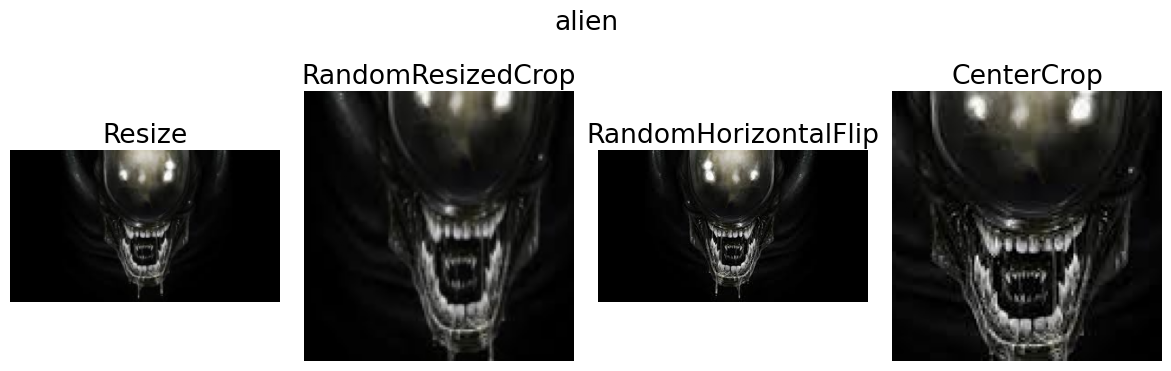

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)

# Look at one image from the dataset
preview_data = ImageFolder(os.path.join("/root/.cache/kagglehub/datasets/pmigdal/alien-vs-predator-images/versions/1", "data", "train"))
img, labels = preview_data[10]

# Let's inspect the effect of the various transformers
fig = plt.figure(figsize=(16, 8))

def show_image(img, labels, transforms_list):
    # permute turns (rgb, height, width) into (height, width, rgb)
    if type(transforms_list) is list:
        fig, axis = plt.subplots(1, len(transforms_list), figsize=(12, 4))

        for i, (transformation, name) in enumerate(transforms_list):
            axis[i].imshow(transformation(img).permute(1, 2, 0))
            axis[i].set_title(name)
            fig.suptitle(class_names[labels])
            axis[i].axis("off")
    # else:
        # img = transforms_list(img)
        # fig, axis = plt.subplots(1, len(img), figsize=(12, 4))

        # for i,( image, label) in enumerate(zip(img, labels)):
        #     axis[i].imshow(img.permute(1, 2, 0))
        #     axis[i].set_title(name)
        #     axis[i].xlabel(class_names[labels])
        #     axis[i].axis("off")

    plt.tight_layout()
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# transform image with some transformations and show them

transformations = [
    (Compose([Resize(128), ToTensor()]), "Resize"),
    (Compose([RandomResizedCrop(128), ToTensor()]), "RandomResizedCrop"),
    (Compose([RandomHorizontalFlip(), ToTensor()]), "RandomHorizontalFlip"),
    (Compose([CenterCrop(128), ToTensor()]), "CenterCrop",)
]

show_image(img, labels, transformations)
#################################################################################
#                                   THE END                                     #
#################################################################################


Note that the transformations above are random, so if you run the cell multiple times, you will see different results.

### Visualize some training samples

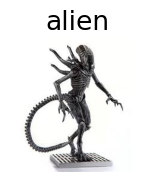

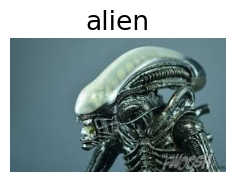

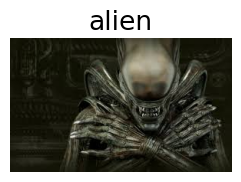

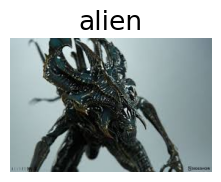

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# show_image(preview_data[:, 0], preview_data[:, 1])
#################################################################################
#                                   THE END                                     #
#################################################################################
for i, j in enumerate([np.random.randint(0, 100) for _ in range(4)]):
    plt.figure(figsize=(16, 8))
    plt.subplot(4, 1, i+1)
    plt.imshow(preview_data[j][0])
    plt.title(class_names[preview_data[j][1]])
    plt.axis("off")


---

# Loading a pre-trained model

### List of available pre-trained models

`torchvision` includes many pre-trained models. Let's get a list and have a look.

In [ ]:
for model in dir(torchvision.models):
    if model.startswith("_"): continue  # Skip private properties
    print(f"- {model}")

- AlexNet
- AlexNet_Weights
- ConvNeXt
- ConvNeXt_Base_Weights
- ConvNeXt_Large_Weights
- ConvNeXt_Small_Weights
- ConvNeXt_Tiny_Weights
- DenseNet
- DenseNet121_Weights
- DenseNet161_Weights
- DenseNet169_Weights
- DenseNet201_Weights
- EfficientNet
- EfficientNet_B0_Weights
- EfficientNet_B1_Weights
- EfficientNet_B2_Weights
- EfficientNet_B3_Weights
- EfficientNet_B4_Weights
- EfficientNet_B5_Weights
- EfficientNet_B6_Weights
- EfficientNet_B7_Weights
- EfficientNet_V2_L_Weights
- EfficientNet_V2_M_Weights
- EfficientNet_V2_S_Weights
- GoogLeNet
- GoogLeNetOutputs
- GoogLeNet_Weights
- Inception3
- InceptionOutputs
- Inception_V3_Weights
- MNASNet
- MNASNet0_5_Weights
- MNASNet0_75_Weights
- MNASNet1_0_Weights
- MNASNet1_3_Weights
- MaxVit
- MaxVit_T_Weights
- MobileNetV2
- MobileNetV3
- MobileNet_V2_Weights
- MobileNet_V3_Large_Weights
- MobileNet_V3_Small_Weights
- RegNet
- RegNet_X_16GF_Weights
- RegNet_X_1_6GF_Weights
- RegNet_X_32GF_Weights
- RegNet_X_3_2GF_Weights
- RegNet_X_4

### We will use the ResNet-18 architecture:
![ResNet-picture](https://github.com/theevann/webconf-pytorch-workshop/blob/master/figures/resnet.png?raw=1)

It's very simple to create a module that has this model with its weights pre-trained for ImageNet.

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# define pre_trained model
from torchvision.models import resnet18, ResNet18_Weights
resnet_model = resnet18(weights=ResNet18_Weights)

#################################################################################
#                                   THE END                                     #
#################################################################################

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### A closer look at the ResNet-18

The last fully connected layer has a 1000 output neurons. It has been trained on ImageNet task which has 1000 image classes.

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# print last layer of model

for name, param in resnet_model.named_children():
    print(name, "-------->", param)

#################################################################################
#                                   THE END                                     #
#################################################################################

conv1 --------> Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 --------> BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu --------> ReLU(inplace=True)
maxpool --------> MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 --------> Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (co

We would like to perform binary classification (alien/predator). Therefore, we have to replace the last fully-connected layer to suit our needs (two output units).

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# replace last layer with suitable layer
resnet_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)

#################################################################################
#                                   THE END                                     #
#################################################################################

---

# Training just the last layer

### Freeze all the layers except the last fully-connected one

**First way**

In [ ]:
from pickle import FALSE
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# Freeze all the layers except the last fully-connected one
for param in resnet_model.parameters():
    param.requires_grad_ = False
for param in resnet_model.fc.parameters():
    param.requires_grad_ = True
#################################################################################
#                                   THE END                                     #
#################################################################################

**Second way**

In [ ]:
######### do not uncomment followings #########

# model_ft.requires_grad_(False)
# model_ft.fc.requires_grad_(True)

**Third way**

A third way could be to pass to the optimiser only the parameters of the last linear layer.  
However, this is not as good as the previous methods, do you see why ?  
Hint: All the gradients are still computed...

### Define the train and accuracy functions

So, now the architecture contains two output units, we can therefore use it to perform binary classification.

The *train* and _accuracy_ function are almost identical to the functions we used when traininig the CNN. This again nicely demonstrates the modularity of PyTorch and its simple interface.

In [ ]:
from tqdm.auto import tqdm, trange
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
def train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    device,
    num_epochs=3,
    learning_rate=0.1,
    decay_learning_rate=False,
):
    model = model.to(device, non_blocking=True)
    opt = optimizer(model.parameters(), lr=learning_rate)
    loss_func = criterion()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.5)
    scaler = torch.amp.GradScaler()
    list_train = []
    list_val = []
    for epoch in trange(num_epochs, desc="running one epoch ...", leave=True):
        running_val_loss = 0.0
        running_train_loss = 0.0
        model.train()
        for x_train, y_train in tqdm(train_loader, desc="training ...", leave=False):
            x_train, y_train = x_train.to(device, non_blocking=True), y_train.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type=device.type):
                train_preds = model(x_train).view(-1)
                train_loss = loss_func(train_preds, y_train.float())
            scaler.scale(train_loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            running_train_loss += train_loss.item() * y_train.size(0)

        model.eval()
        with torch.inference_mode():
            for x_val, y_val in tqdm(test_loader, desc="evaluating ...", leave=False):
                x_val, y_val = x_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                with torch.amp.autocast(device_type=device.type):
                    val_logits = model(x_val).view(-1)
                    val_loss = loss_func(val_logits, y_val.float())
                running_val_loss += val_loss.item() * y_val.size(0)
            list_train.append(running_train_loss / len(train_loader.dataset))
            list_val.append(running_val_loss / len(test_loader.dataset))
            print(f"test loss --> {running_val_loss / len(test_loader.dataset)}")
            print(f"train loss --> {running_train_loss / len(train_loader.dataset)}")
            if decay_learning_rate:
                scheduler.step(running_train_loss / len(train_loader.dataset))
                print(scheduler.get_last_lr()[0])
    return list_val, list_train, model

#################################################################################
#                                   THE END                                     #
#################################################################################

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################

# define accuracy function
import torch.nn.functional as F
def accuracy_def(model, loader, device):
    model.eval()
    corrects = 0
    total = 0

    with torch.inference_mode():
        for x_val, y_val in tqdm(loader, desc="evaluating ...", leave=False):
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_logits = model(x_val).squeeze()
            preds = F.sigmoid(val_logits) >= 0.5
            corrects += (preds == y_val).sum()
            total += y_val.shape[0]
    return (corrects / total).item()
#################################################################################
#                                   THE END                                     #
#################################################################################

### Launch training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

list_val, list_train, model = train(
    resnet_model,
    nn.BCEWithLogitsLoss,
    torch.optim.AdamW,
    train_loader,
    test_loader,
    device,
    num_epochs=100,
    learning_rate=0.1,
    decay_learning_rate=True,
)

running one epoch ...:   0%|          | 0/100 [00:00<?, ?it/s]

training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9059757614135742
train loss --> 1.610235136592766
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> nan
train loss --> 1.5995533562531046
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8564187574386597
train loss --> 1.184059172782843
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8226993083953857
train loss --> 0.9800321884904196
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.050025634765625
train loss --> 0.799416509073131
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.1814542722702026
train loss --> 0.8215064756808432
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 2.0331769466400145
train loss --> 0.8142626392910047
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.8346205711364747
train loss --> 0.7466186473967362
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6578677821159363
train loss --> 0.7421193428616703
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7959956806898117
train loss --> 0.6921965334704011
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8871650218963623
train loss --> 0.6183500011647469
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.3320615196228027
train loss --> 0.648110238378948
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 2.6553297036886216
train loss --> 0.6253766761045978
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.534490659236908
train loss --> 0.628378348194213
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.805829246044159
train loss --> 0.6021056733488693
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6209797263145447
train loss --> 0.590441873162899
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9106750011444091
train loss --> 0.6096821889410101
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9717571616172791
train loss --> 0.6100693925656915
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6620893859863282
train loss --> 0.6270344745185258
0.1


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.70683673620224
train loss --> 0.6005266408411845
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5147017252445221
train loss --> 0.5774548019387193
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5017326939105987
train loss --> 0.5191716668585192
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8507260060310364
train loss --> 0.5296600522843836
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6229373568296432
train loss --> 0.5330380323297352
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6512647080421448
train loss --> 0.5081853072993694
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7556993669271469
train loss --> 0.5354242585921494
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5511974799633026
train loss --> 0.5412188826789086
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5426760458946228
train loss --> 0.5199582221185096
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4992774593830109
train loss --> 0.4994762236687223
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7368718338012695
train loss --> 0.5313455849800055
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7326815509796143
train loss --> 0.5190404928383291
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9258324265480041
train loss --> 0.5042484229167532
0.05


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.626084053516388
train loss --> 0.5569925758268373
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5026057755947113
train loss --> 0.48920465477605374
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5268448233604431
train loss --> 0.4756585978808939
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6809527814388275
train loss --> 0.4644845353079804
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5193477487564087
train loss --> 0.4943125381936945
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5367168509960174
train loss --> 0.45389792950077773
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6055926990509033
train loss --> 0.41412101192158307
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8143752717971802
train loss --> 0.44801083894215676
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6467311096191406
train loss --> 0.4379656742560417
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4795131349563599
train loss --> 0.42089033281425237
0.025


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5032272481918335
train loss --> 0.47118120423655
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5665189337730407
train loss --> 0.40333558193888375
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5621656036376953
train loss --> 0.3831118664755258
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4749337875843048
train loss --> 0.347363773787056
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6410432052612305
train loss --> 0.3478484450911926
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4633003032207489
train loss --> 0.3351462095202905
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5303213787078858
train loss --> 0.33060537875557494
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5020041263103485
train loss --> 0.31166481404895396
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5307871460914612
train loss --> 0.3440857410259137
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6631930828094482
train loss --> 0.2672907993712755
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5859827828407288
train loss --> 0.30620929315385625
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.508782799243927
train loss --> 0.2737307849337457
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.553732693195343
train loss --> 0.2656835118356974
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.4947840666770935
train loss --> 0.2397976214930372
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7162453651428222
train loss --> 0.2295931608601331
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7653865623474121
train loss --> 0.24172793187050723
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5458326858282089
train loss --> 0.22312824307841594
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.209165997505188
train loss --> 0.19574026303950923
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.585545369386673
train loss --> 0.2138314929492879
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7065072393417359
train loss --> 0.20899748138718371
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.743980382680893
train loss --> 0.1662458787733952
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.538896232843399
train loss --> 0.22552629609616415
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8380386114120484
train loss --> 0.2399105360940829
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6237568569183349
train loss --> 0.2013501242361426
0.0125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 1.069480128288269
train loss --> 0.20199216631716196
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5711817276477814
train loss --> 0.17895063453002347
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6320759654045105
train loss --> 0.16048810319701257
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6514539670944214
train loss --> 0.1259421943673483
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.5959839475154877
train loss --> 0.13991773207953753
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6901849126815796
train loss --> 0.10643309202335066
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7311558485031128
train loss --> 0.11695253284331357
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7308457326889038
train loss --> 0.08865935367770944
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8317676639556885
train loss --> 0.0498534407284143
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8914725828170776
train loss --> 0.11695299144050574
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.667773003578186
train loss --> 0.09183360357642689
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.6903475022315979
train loss --> 0.08029527426496019
0.00625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8232654285430908
train loss --> 0.09483413972626159
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7606357717514038
train loss --> 0.10291000397108302
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7629278326034545
train loss --> 0.06762187013883005
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7234325909614563
train loss --> 0.051606740330155366
0.003125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7738195037841797
train loss --> 0.09004337374545011
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.832445101737976
train loss --> 0.06009085519341296
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8372856760025025
train loss --> 0.033159486707890415
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8357023596763611
train loss --> 0.04956143916254428
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.7959970664978028
train loss --> 0.05070940155323906
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8125281476974487
train loss --> 0.02748076778887543
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8279961705207824
train loss --> 0.04335811397500916
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8829907703399659
train loss --> 0.03364910118205349
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8701350784301758
train loss --> 0.019804260186228353
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8634498119354248
train loss --> 0.02320981087560312
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8950537347793579
train loss --> 0.044001355697467964
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8963156938552856
train loss --> 0.03726776032802523
0.0015625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9013525676727295
train loss --> 0.05642199647272011
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.9506534099578857
train loss --> 0.02465603246705161
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8513539171218872
train loss --> 0.042013211395881364
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8519826316833496
train loss --> 0.022996610484115502
0.00078125


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8886933135986328
train loss --> 0.0430993026986172
0.000390625


training ...:   0%|          | 0/44 [00:00<?, ?it/s]

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

test loss --> 0.8527735042572021
train loss --> 0.025811947302447274
0.000390625


### Inspecting the model's predictions

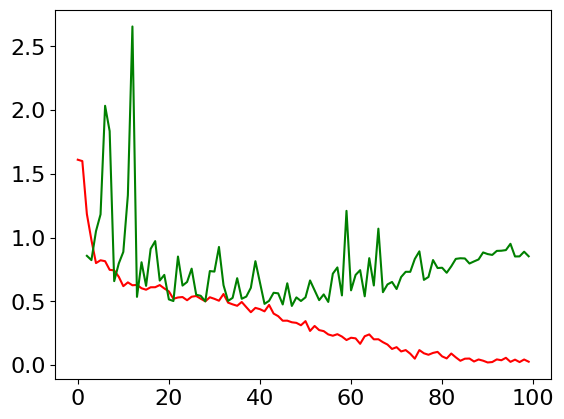

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# show some predictions
import matplotlib.pyplot as plt
plt.plot(list_train, c="red")
plt.plot(list_val, c="green")

#################################################################################
#                                   THE END                                     #
#################################################################################

In [ ]:
accuracy_def(model, test_loader, device)

evaluating ...:   0%|          | 0/4 [00:00<?, ?it/s]

0.7799999713897705